In [83]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [84]:
dataset_dir = "rgbd_dataset_freiburg1_room"

depth_dir = dataset_dir + "/depth"
depth_image_paths = sorted(os.listdir(depth_dir))
ri = int(np.random.randint(len(depth_image_paths)-10))
depth_images = [cv2.imread(depth_dir + "/" + depth_image_path, cv2.IMREAD_UNCHANGED) for depth_image_path in depth_image_paths[ri:ri+2]]
depth_images = [depth_image.astype(float) / 5000.0 for depth_image in depth_images]

rgb_dir = dataset_dir + "/rgb"
rgb_image_paths = sorted(os.listdir(rgb_dir))
rgb_images = [cv2.imread(rgb_dir + "/" + rgb_image_path, cv2.IMREAD_COLOR) for rgb_image_path in rgb_image_paths[ri:ri+2]]

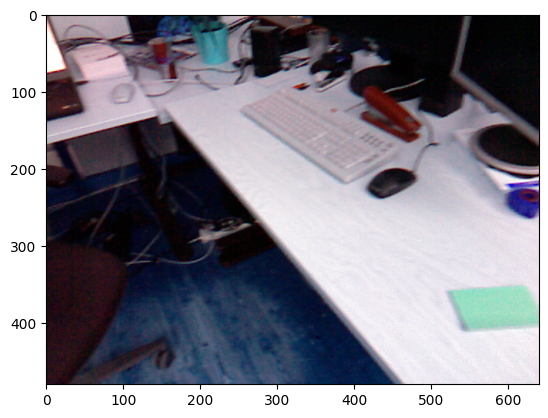

In [85]:
plt.imshow(rgb_images[0])

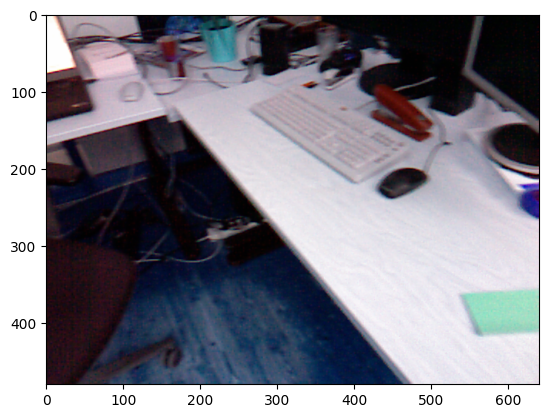

In [86]:
plt.imshow(rgb_images[1])

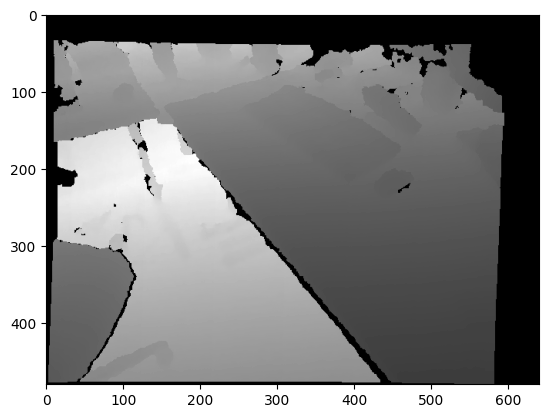

In [87]:
plt.imshow(depth_images[0], cmap="gray")

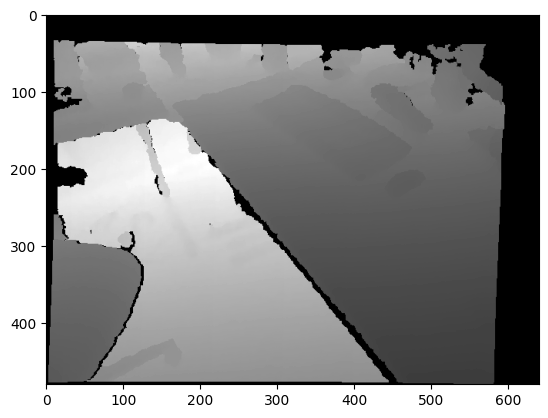

In [88]:
plt.imshow(depth_images[1], cmap="gray")

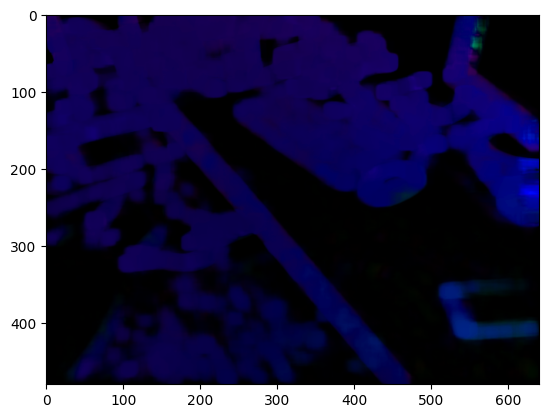

In [89]:
# compute optical flow between two consecutive RGB frames
gray = [cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY) for rgb_image in rgb_images]
flow = cv2.calcOpticalFlowFarneback(gray[0], gray[1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv = np.zeros_like(rgb_images[0])
hsv[...,1] = 255
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
plt.imshow(bgr)

In [98]:
# compute real world velocity, from ground truth txt file
with open(dataset_dir + "/groundtruth.txt") as f:
    lines = f.readlines()
    lines = [line.split(" ") for line in lines if line[0] != "#"]
    lines = [[float(x) for x in line] for line in lines]
    lines = np.array(lines)
# depth_image_paths[ri:ri+2]
ts0 = float(".".join(depth_image_paths[ri].split(".")[:2]))
ts1 = float(".".join(depth_image_paths[ri+1].split(".")[:2]))
print(ts0)
print(ts1)
dt = ts1 - ts0
# find closest ground truth timestamp
idx0 = np.argmin(np.abs(lines[:, 0] - ts0))
idx1 = np.argmin(np.abs(lines[:, 0] - ts1))
print(lines[idx0, 0])
print(lines[idx1, 0])
dp = lines[idx1, 1:4] - lines[idx0, 1:4]
vel = dp / dt  # (lines[idx1, 0] - lines[idx0, 0])
np.linalg.norm(vel), dt, dp

1305031932.192165
1305031932.227671
1305031932.189
1305031932.229


(0.3223176158974816, 0.03550601005554199, array([ 0.0026, -0.0111, -0.001 ]))

In [104]:
# get non-zero depth pixel coordinates with magnitude of rgb optical flow around the average
depth_image = depth_images[1]
mag_mask = np.logical_and(mag > 6.0, mag < 13.0)
mask = np.logical_and(mag_mask, depth_image > 0.1)
print(flow[mask].mean(axis=0), mask.sum(), np.max(mag), np.median(mag))

# solve least squares
b = flow[mask].reshape(-1) / dt
# weight these by inverse of magnitude
d = depth_image[mask]
fx = 517.3
fy = 516.5
A = np.zeros((b.shape[0], 6))
uv = np.argwhere(mask)
for i in range(uv.shape[0]):
    u, v = uv[i]
    A[i * 2, :] = [
        fx / d[i], 0, -u / d[i], -(u*v)/fx, (fx**2 + u**2)/fx, -v
    ]
    A[i * 2 + 1, :] = [
        0, fy / d[i], -v / d[i], (-fy**2 - v**2)/fy, (u*v)/fy, u
    ]
x, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
np.linalg.norm(x[:3])

[10.283333  -1.3884789] 102867 35.00789 6.7577972


0.46651727912675134

In [92]:
# # replace least squares with ransac
# from sklearn import linear_model
# ransac = linear_model.RANSACRegressor(
#     max_trials=1000,
#     stop_probability=0.99,
#     min_samples=10,
# )
# ransac.fit(A, b)
# print(np.linalg.norm(ransac.estimator_.coef_[:3]), ransac.n_trials_,
#       ransac.inlier_mask_.sum(), ransac.score(A, b))

In [93]:
# # use PyrLK
# # params for ShiTomasi corner detection
# feature_params = dict(maxCorners=100,
#                       qualityLevel=.3,
#                       minDistance=7,
#                       blockSize=7)
# # Parameters for lucas kanade optical flow
# lk_params = dict(winSize=(15, 15),
#                  maxLevel=2,
#                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# p0 = cv2.goodFeaturesToTrack(gray[0], mask=None, **feature_params)
# p1, st, err = cv2.calcOpticalFlowPyrLK(gray[0], gray[1], p0, None, **lk_params)
# good_new = p1[st == 1]
# good_old = p0[st == 1]
# flow = (good_new - good_old) / dt

# print(f"Number of features: {good_new.shape}")

# # get corresponsing depth values
# depth_image = depth_images[1]
# depth = depth_image[good_new[:, 1].astype(int), good_new[:, 0].astype(int)]
# depth_zero_mask = depth > 0.1
# uv = good_new[depth_zero_mask]
# d = depth[depth_zero_mask]

# b = flow.reshape(-1)
# fx = 517.3
# fy = 516.5
# # fx = fy = (fx+fy)/2
# A = np.zeros((b.shape[0], 6))
# for i in range(uv.shape[0]):
#     u, v = uv[i]
#     A[i * 2, :] = [
#         fx / d[i], 0, -u / d[i], -(u*v)/fx, (fx**2 + u**2)/fx, -v
#     ]
#     A[i * 2 + 1, :] = [
#         0, fy / d[i], -v / d[i], (-fy**2 - v**2)/fy, (u*v)/fy, u
#     ]
# x, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
# print(np.linalg.norm(x))

# ransac = linear_model.RANSACRegressor(
#     max_trials=1000,
#     stop_probability=0.99,
#     # min_samples=12,
# )
# ransac.fit(A, b)
# print(np.linalg.norm(ransac.estimator_.coef_[:3]), ransac.n_trials_,
#       ransac.inlier_mask_.sum(), ransac.score(A, b))
# np.linalg.norm(vel)